In [1]:
#importing all the required libraries

import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

# Undistorting the images
Read all the input images for calibrating the camera images.

In [2]:
def read_calib_images():
    input_images = glob.glob('camera_cal/*.jpg')
    calib_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        calib_imgs.append(img)
        
    return calib_imgs

def read_test_images():
    input_images = glob.glob('test_images/*.jpg')
    test_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        test_imgs.append(img)
        
    return test_imgs


Function to find corners in chess board, and seperate the images in which the corners cannot be detected

In [3]:
def find_corners(imgs, x, y):
    points_3D = [] 
    points_2D = [] 
    
    corners_not_detected = [] 
    corners_detected = [] 
    
    obj_3D = np.zeros((x * y, 3), np.float32)
    obj_3D[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1, 2)
    
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_img, (x, y), None)
        
        if ret == True:
            points_3D.append(obj_3D)
            points_2D.append(corners)
            corners_detected.append(img)
        else:
            corners_not_detected.append(img)
            
    return points_3D, points_2D, corners_detected, corners_not_detected

Testing the functionality of Corners detected and not detected in the list of input images

Number of images in which corners were detected =  17
Number of images in which corners were not detected =  3

images of corners detected


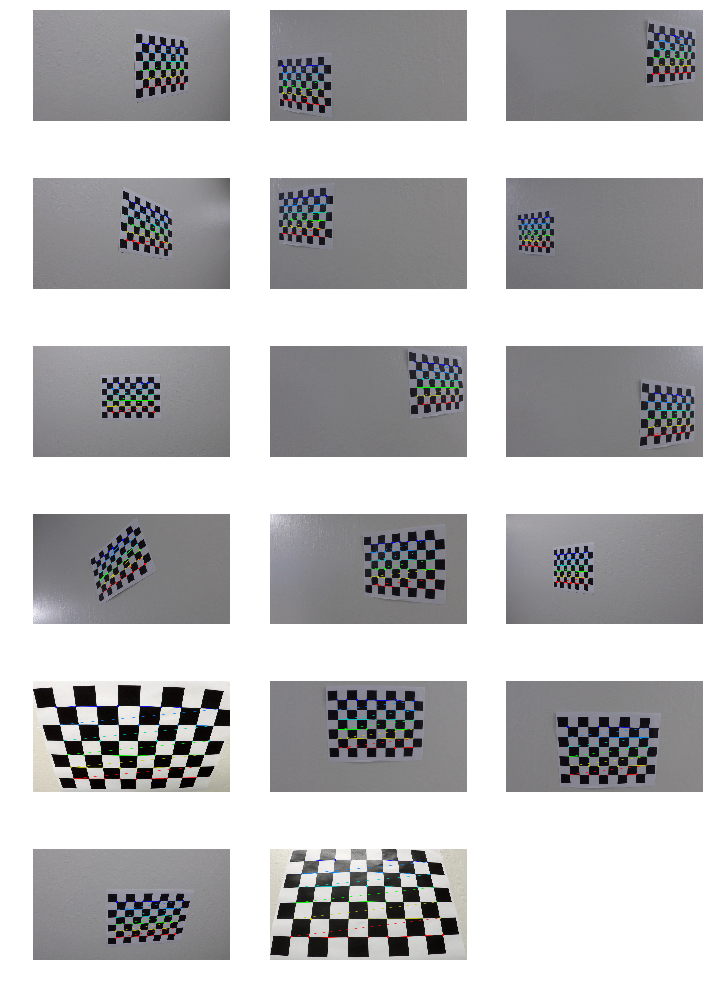


images of corners not detected


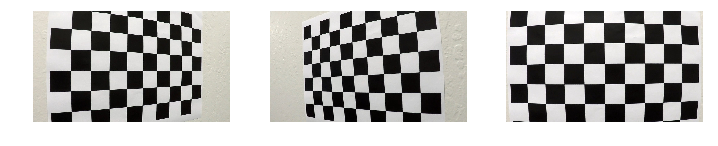

In [4]:
#Number of corners to be found
no_x = 9
no_y = 6

calib_imgs = read_calib_images()
points_3D, points_2D, corners_detected, corners_not_detected = find_corners(calib_imgs, no_x, no_y)

print("Number of images in which corners were detected = ", len(corners_detected))
print("Number of images in which corners were not detected = ", len(corners_not_detected))

# view the images
print("")
print("images of corners detected")
plt.figure(figsize=(12, 18))
for idx, img in enumerate(corners_detected):
    cv2.drawChessboardCorners(img, (no_x, no_y), points_2D[idx], True)
    plt.subplot(6, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()

print("")
print("images of corners not detected")
plt.figure(figsize=(12, 3))
for idx, img in enumerate(corners_not_detected):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()



Since the number of x and y corners to be detected is more than the number of corners that could be observed in the previous 3 images, it is classified as not detected

Function to undistort an image

In [5]:
def get_calibration_value(img, points_3D, points_2D):
    
    img_shape = (img.shape[0], img.shape[1])
    
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, points_2D, img_shape, None, None)
    return mtx, dist

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

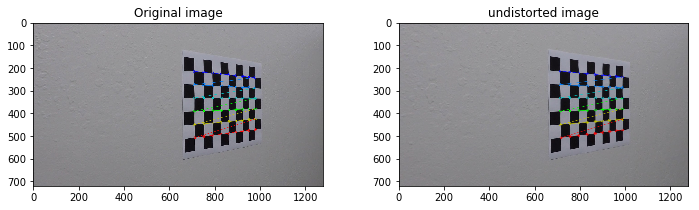

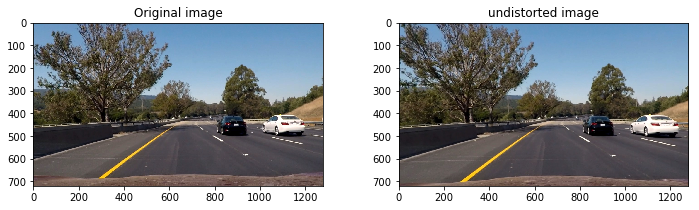

In [6]:
mtx, dist = get_calibration_value(corners_detected[0], points_3D, points_2D)

calibration_value = {}
calibration_value["mtx"] = mtx
calibration_value["dist"] = dist
pickle.dump( calibration_value, open( "calibration_value.p", "wb" ) )

undist_img = undistort_img(corners_detected[0], mtx, dist)

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(corners_detected[0])
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undist_img)
plt.show()

test_imgs = read_test_images()
test_img = test_imgs[3]
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undistort_img(test_img, mtx, dist))
plt.show()

# Pipeline for lane detection
Convert the images to binary format

In [7]:
def convert_to_binary(img, sobel_thresh=(25,255), s_thresh=(125, 255), l_thresh=(125,255)):
    
    raw_img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    # Sobel x
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary = np.zeros_like(sx_binary)
    binary[((l_binary == 1) & (s_binary == 1) | (sx_binary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return binary

Testing the binary functionality

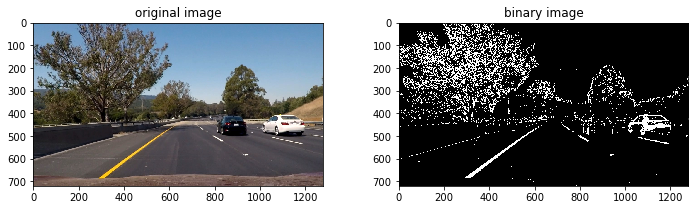

In [8]:

binary = convert_to_binary(test_img)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.title("binary image")
plt.show()

Warping the images

In [9]:
# depending on the requirement of top view or camera view, warp the image
def img_warp(img, top_view=True):
    
    src = np.float32(
        [[120, 720],
         [580, 450],
         [750, 450],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    img_shape = (img.shape[1], img.shape[0])
    
    if top_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
        
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    return warped_img

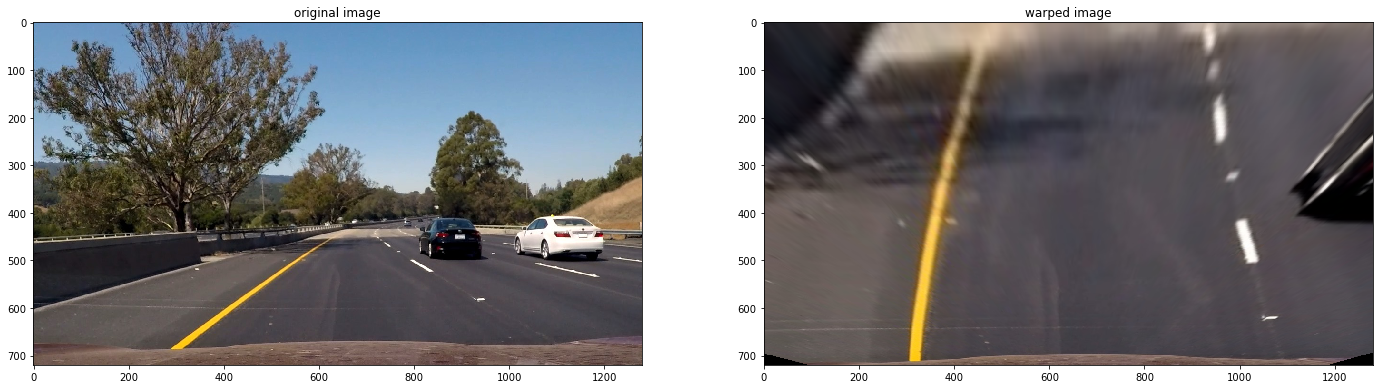

In [10]:

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]

undist_img = undistort_img(test_img, mtx, dist)
warped_img = img_warp(undist_img)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(warped_img)
plt.title("warped image")
plt.show()

In [11]:
def img_msk(img):
    points = np.array([[(0,img.shape[0]),(580, 450), (750, 450), (img.shape[1],img.shape[0])]], dtype=np.int32)
    msk = np.zeros_like(img)
    
    no_of_channels = img.shape[2]
    msk_color = (255, ) * no_of_channels
    
    cv2.fillPoly(msk, points, msk_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, msk)
    return masked_image

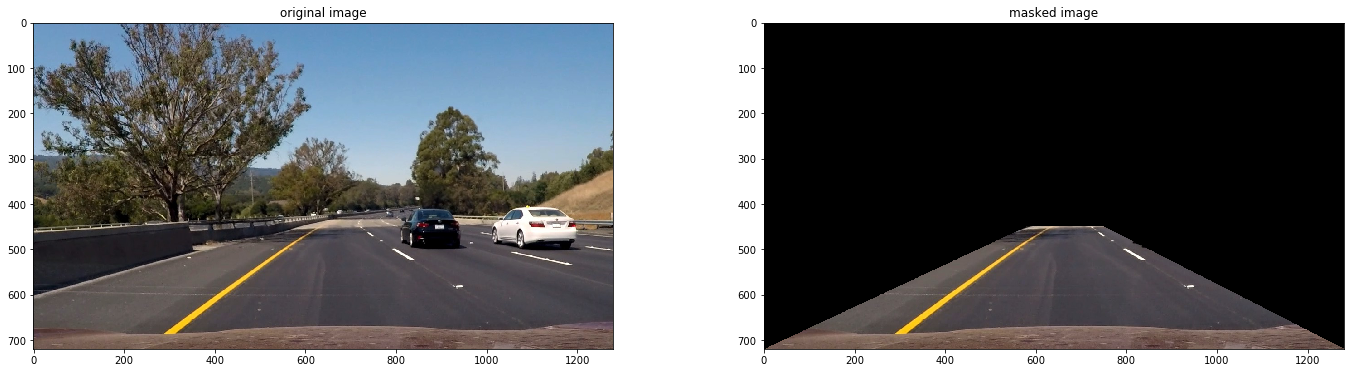

In [12]:
msk_img = img_msk(test_img)

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_imgs[3])
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("masked image")
plt.show()

Pipeline functionality

In [13]:
def warp_pipe(img, mtx, dist):
    undist_img = undistort_img(img, mtx, dist)
    bin_img = convert_to_binary(undist_img)
    msked_img = img_msk(bin_img)
    warp_img = img_warp(msked_img)
    
    return warp_img

Testing the warp pipeline

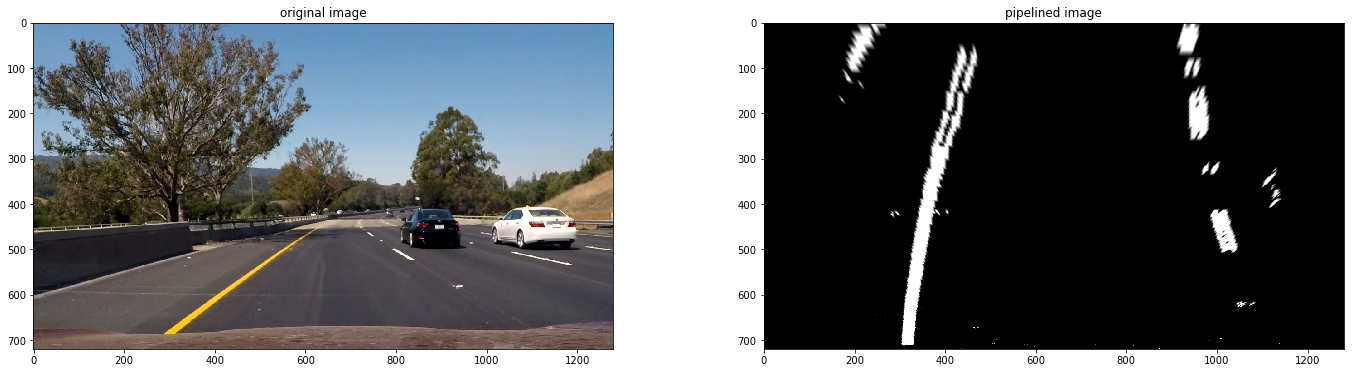

In [14]:
msk_img = warp_pipe(test_img, mtx, dist)


plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("pipelined image")
plt.show()

In [28]:
def histogram_peaks(img):
    mid_point = img[img.shape[0] // 2 :, :]
    histogram = np.sum(mid_point, axis=0)
    return histogram
    
def sliding_window(img):
    hist = histogram_peaks(img)
    
    mid = np.int(hist.shape[0] // 2)
    left_x_base = np.argmax(hist[:mid])
    right_x_base = np.argmax(hist[mid:]) + mid
    
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
   
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    margin = 80
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (leftx, lefty), (rightx, righty)


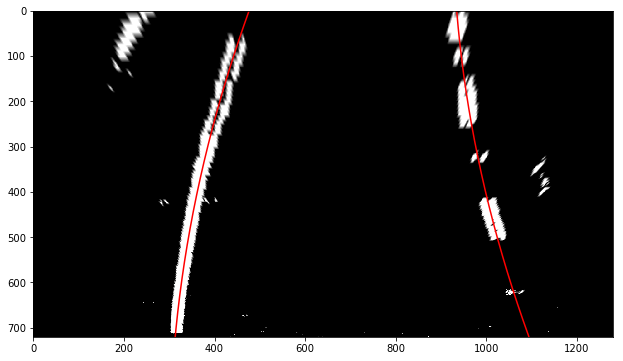

In [29]:
msk_bin_img = msk_img[:, :, 0]
plt.figure(figsize=(24,6))
left_fit, right_fit, left_ind, right_ind = sliding_window(msk_bin_img)
x = test_img.shape[0]

left_fit_x_int = left_fit[0]*x**2 + left_fit[1]*x + left_fit[2]
right_fit_x_int = right_fit[0]*x**2 + right_fit[1]*x + right_fit[2]

out_img = np.uint8(np.dstack((msk_bin_img, msk_bin_img, msk_bin_img))*255)
ploty = np.linspace(0, msk_bin_img.shape[0]-1, msk_bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
nonzero = msk_bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
plt.imshow(msk_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.show()

Draw lane onto the original image

In [30]:
def draw_lane(org_img, msk_bin_img, left_fit, right_fit):
    
    new_img = np.copy(org_img)
    # if there is no left and right fit then return the original image
    if left_fit is None or right_fit is None:
        return original_img
    
    # An image of the shape of original image to draw the lane and overlay on top of original image
    warp_zero = np.zeros_like(msk_bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    y,x = msk_bin_img.shape
    ploty = np.linspace(0, y-1, num=y)
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # stack x and y coodinates, which can be used in fill poly function
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,255,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=15)

    # Warp the blank back to original image space
    inv_warp = img_warp(color_warp, top_view=False) 
    
    # Combine the lane image with the original image
    result = cv2.addWeighted(new_img, 1, inv_warp, 0.25, 0)
    return result, ploty
    

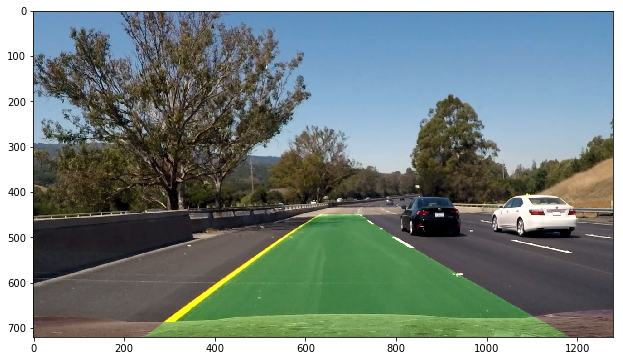

In [31]:
lane_img, ploty = draw_lane(test_img, msk_bin_img, left_fit, right_fit)
plt.figure(figsize=(12,6))
plt.imshow(lane_img)
plt.show()

Calculation of Radius of curvature

In [69]:
def radius_of_curvature(ploty, l_fit, r_fit, left_lane_inds, right_lane_inds, img_shape):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * l_fit[0] * y_eval + l_fit[1]) ** 2) ** 1.5) / np.absolute(2 * l_fit[0])
    right_curverad = ((1 + (2 * r_fit[0] * y_eval + r_fit[1]) ** 2) ** 1.5) / np.absolute(2 * r_fit[0])

    # Define conversions in x and y from pixels space to meters
    y_met_per_pix = 8 / 270 # meters per pixel in y dimension
    x_met_per_pix = 3.7 / 800 # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = left_lane_inds[0]
    lefty = left_lane_inds[1] 
    rightx = right_lane_inds[0]
    righty = right_lane_inds[1]
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty * y_met_per_pix, leftx * x_met_per_pix, 2)
    right_fit = np.polyfit(righty * y_met_per_pix, rightx * x_met_per_pix, 2)
    
    # Calculate radius of curvature
    left_curve_radians = ((1 + (2 * left_fit[0] * y_eval * y_met_per_pix + left_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * left_fit[0])
    right_curve_radians = ((1 + (2 * right_fit[0] * y_eval * y_met_per_pix + right_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * right_fit[0])
    radius = round(np.mean([left_curve_radians, right_curve_radians]), 0) / 1000
    radius_text = "Radius of Curvature = {} km".format(round(radius, 4))
    
    # Calculating middle of the image, aka where the car camera is
    mid_img = img_shape[1] / 2
    car_pos = mid_img * x_met_per_pix
    
    # To calculate distance from center, Finds the base of the line at the bottom of the image.
    x = img_shape[0] * y_met_per_pix
    left_base_line = (left_fit[0] * x **2) + (left_fit[1] * x) + left_fit[2]
    right_base_line = (right_fit[0] * x **2) + (right_fit[1] * x) + right_fit[2]
    mid = (left_base_line + right_base_line) / 2
    dev_from_center = (mid - car_pos) * 100
    
    if dev_from_center >= 0:
        dev_text = "Car is {} cm left of center".format(round(dev_from_center, 4))
    else:
        dev_text = "Car is {} cm right of center".format(round(dev_from_center, 4))
        
    
    return radius_text, dev_text

In [70]:
warp_img = warp_pipe(test_img, mtx, dist)
warp_bin_img = warp_img[:, :, 0]

l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)

img_out, ploty = draw_lane(test_img, warp_bin_img, l_fit, r_fit)
rad, dev = radius_of_curvature(ploty, l_fit, r_fit, l_lane_inds, r_lane_inds, test_img.shape)
print(rad)
print(dev)

Radius of Curvature = 0.501 km
Car is 29.4178 cm left of center


In [ ]:
class Line():
    def __init__(self, n = 10):
        # length of queue to store data
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [54]:
def processing_pipeline(img):
    new_img = np.copy(img)
    warp_img = warp_pipe(new_img, mtx, dist)
    warp_bin_img = warp_img[:, :, 0]
    
    l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)
    
    img_out, ploty = draw_lane(new_img, warp_bin_img, l_fit, r_fit)
    rad, dev = radius_of_curvature(ploty, l_fit, r_fit, l_lane_inds, r_lane_inds, new_img.shape)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 2)
    cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 2)
    
    return img_out

In [55]:
from moviepy.editor import VideoFileClip
"""
left_line = Line()
right_line = Line()
"""
input_video = VideoFileClip('project_video.mp4').subclip(20,25)
processed_video = input_video.fl_image(processing_pipeline)

output_video = 'project_video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 99%|█████████▉| 125/126 [00:20<00:00,  5.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 28.8 s, sys: 488 ms, total: 29.3 s
Wall time: 22.7 s


In [56]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))